In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import os
import random
import warnings
warnings.filterwarnings('ignore')

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Set image_size and batch_size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Target Directory
trainDIr = "./Train/"
valDIr = "./Valid/"



# Train Data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
             trainDIr,
             image_size=IMAGE_SIZE,
             batch_size=BATCH_SIZE,
             seed=42)

# Valid data
valid_data = tf.keras.preprocessing.image_dataset_from_directory(
            valDIr,
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
             seed=42)

Found 24069 files belonging to 37 classes.
Metal device set to: AMD Radeon RX 5700 XT
Found 2545 files belonging to 37 classes.


2021-09-23 16:48:03.865953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-23 16:48:03.867000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-23 16:48:03.867742: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
class_names = train_data.class_names
class_names

['Armoise-Artemisia-vulgaris',
 'Aubépines',
 'Cassisiers',
 'Cerisier-japon',
 'Cerisiers',
 'Chardons',
 'Cheiranthus-Erysimum-Cheiri-Giroflée',
 'Ciseaux',
 'Citronnelle',
 'Coucous',
 'Couteaux',
 'Framboisier',
 'Genévrier',
 'Graminé',
 'Hellébore-fétide',
 'Iris-Bleu',
 'Iris-rouge',
 'Menthe-Poivrée',
 'MillePertuis',
 'Mourons-Blanc',
 'Mourons-Bleu',
 'Orties',
 'Pâquerrettes',
 'Pissenlits',
 'Plantain-lancéolé',
 'Pruniers',
 'Pulmonaire-feuilles-longues',
 'Pyracantha',
 'Renoncule-rampante',
 'Renoncules',
 'Roquette',
 'Roses-Trémières',
 'Rosiers',
 'Sauges-Sauvages',
 'Trèfle',
 'Violettes',
 'Vipérines']

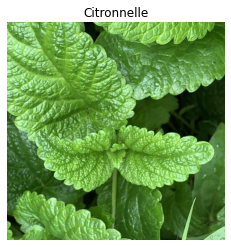

In [4]:
img = plt.imread("./Valid/Citronnelle/IMG_8621_imcro.jpg")
plt.imshow(img)
plt.title("Citronnelle")
plt.axis("off")
plt.show();

In [5]:
def preprocess_image(image, label, image_shape=224):
    
    img = tf.image.resize(image, [image_shape, image_shape])
    img = img/225.
    
    return tf.cast(img, tf.float32), label

In [6]:
preprocess_image(image=img, label='Roquette')

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.39192742, 0.6497053 , 0.2760544 ],
         [0.55417234, 0.80839   , 0.44573697],
         [0.43124706, 0.68458045, 0.33941036],
         ...,
         [0.19682555, 0.39682558, 0.03659878],
         [0.21308391, 0.4130839 , 0.04419501],
         [0.20412679, 0.4041268 , 0.02634901]],
 
        [[0.7226984 , 0.9764852 , 0.6071428 ],
         [0.43811792, 0.69589573, 0.3190703 ],
         [0.6167347 , 0.8745125 , 0.49768713],
         ...,
         [0.21841286, 0.41841286, 0.05841285],
         [0.23015873, 0.43015873, 0.06126984],
         [0.2199998 , 0.4199998 , 0.05111092]],
 
        [[0.6911564 , 0.94893414, 0.5711564 ],
         [0.47968245, 0.7415646 , 0.33809516],
         [0.60489804, 0.8699774 , 0.44761914],
         ...,
         [0.21752861, 0.41308415, 0.06197304],
         [0.24600914, 0.44600916, 0.08600914],
         [0.25015873, 0.45015875, 0.08993184]],
 
        ...,
 
        [[0.48156476, 0.77934253

In [7]:
# map the preprocess_image to train_data
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle the data
train_data = train_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# map the preprocess_image to valid_data
valid_data = valid_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle the data
valid_data = valid_data.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
train_data, valid_data


(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>)

In [9]:
# Set random seed
tf.random.set_seed(42)

# model 1
model_1 = Sequential([
    Conv2D(filters=32, kernel_size=4, padding='same', activation='relu',input_shape=(224,224,3)),
    MaxPool2D(2,2),
    Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPool2D(2,2), 
    Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(len(class_names), activation='softmax')
])

# Compile
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

# Fit
history_1 = model_1.fit(train_data,
                       epochs=1,
                       validation_data=valid_data)

2021-09-23 16:48:04.583943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-23 16:48:04.585795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-23 16:48:14.656204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 518 of 1000
2021-09-23 16:48:18.989622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


753/753 [==============================] - ETA: 0s - loss: 1.7359 - accuracy: 0.5196

2021-09-23 16:49:42.390632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - 102s 114ms/step - loss: 1.7359 - accuracy: 0.5196 - val_loss: 2.1980 - val_accuracy: 0.5187


In [10]:
print(len(class_names))

37


In [11]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0

In [12]:
def plot_loss_curves(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

  # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

  # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

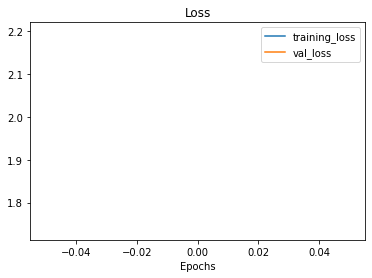

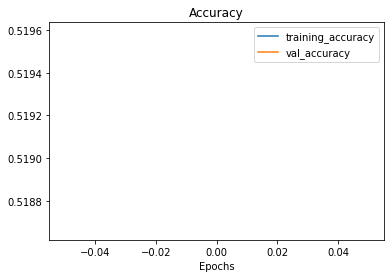

In [13]:
plot_loss_curves(history=history_1)

Model baseline_model_efficientnetb5

In [14]:
# Download base model
baseline_model_efficientnetb5 = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False)

# Freeze the layer
baseline_model_efficientnetb5.trainable = False

# Inputs
inputs = tf.keras.layers.Input(shape=(224,224,3))

# Recaling
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# pass inputs to our model
x = baseline_model_efficientnetb5(inputs, training=False)

# Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# outputs
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# model_6
model_6 = tf.keras.Model(inputs, outputs)

# Compile
model_6.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

# Summary
model_6.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb5 (Functional)  (None, None, None, 2048)  28513527  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 37)                75813     
Total params: 28,589,340
Trainable params: 75,813
Non-trainable params: 28,513,527
_________________________________________________________________


In [ ]:
# Fit the model
history_6 = model_6.fit(train_data,
                       epochs=50,
                       validation_data=valid_data)

Epoch 1/50


2021-09-23 16:50:17.642869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-23 16:50:28.457730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 503 of 1000
2021-09-23 16:50:33.324967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


753/753 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0122

2021-09-23 16:53:04.797709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


753/753 [==============================] - 192s 225ms/step - loss: nan - accuracy: 0.0122 - val_loss: nan - val_accuracy: 0.0291
Epoch 2/50


2021-09-23 16:53:33.424313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 475 of 1000
2021-09-23 16:53:39.097474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


753/753 [==============================] - 183s 222ms/step - loss: nan - accuracy: 0.0120 - val_loss: nan - val_accuracy: 0.0291
Epoch 3/50


2021-09-23 16:56:36.404531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 455 of 1000
2021-09-23 16:56:42.845712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


753/753 [==============================] - 183s 221ms/step - loss: nan - accuracy: 0.0120 - val_loss: nan - val_accuracy: 0.0291
Epoch 4/50


2021-09-23 16:59:39.497424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 442 of 1000
2021-09-23 16:59:46.418532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


617/753 [=======================>......] - ETA: 27s - loss: nan - accuracy: 0.0119

In [ ]:
plot_loss_curves(history=history_6)

In [ ]:
base_model_inception.summary()


In [ ]:
## inceptionv3 architecture
from tensorflow.keras.utils import plot_model
plot_model(base_model_inception)

In [ ]:
base_model_inception.trainable = True

# freeze all layers except last 15
for layer in base_model_inception.layers[:-15]:
    layer.trainable = False

# Recompile the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

In [ ]:
# refit the model
history_model_4_fine_tune = model_4.fit(train_data,
                                       epochs=10,
                                       validation_data=valid_data,
                                       initial_epoch=history_4.epoch[-1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
from helper_functions import compare_historys

In [ ]:
compare_historys(history_4,
                history_model_4_fine_tune)

In [ ]:
# save the best performing model
model_4.save("output/best_performing_model")

In [ ]:
# load model
loaded_model = tf.keras.models.load_model("output/best_performing_model")
loaded_model

In [ ]:
# Evaluate
loaded_model.evaluate(valid_data)

In [ ]:
pred_probs = loaded_model.predict(valid_data)
pred_probs[:10]

In [ ]:
pred_class = pred_probs.argmax(axis=1)
pred_class[:10]